## Ejecutar las simulaciones


In [4]:
schedule_names = ['fcfs']
nombres = ' '.join(schedule_names)

In [3]:
%%bash -s "$nombres"
cd ..
./utils/scripts/run-sim.sh $1

time="2023-11-15 18:00:17.603" level=info msg="Waiting for valid context" batsim command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/fcfs/fcfs" extracted socket endpoint="tcp://localhost:28000" ready timeout (seconds)=10
time="2023-11-15 18:00:17.618" level=info msg="Starting simulation" batsim cmdfile=output/fcfs/fcfs/cmd/batsim.bash batsim command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/fcfs/fcfs" batsim logfile=output/fcfs/fcfs/log/batsim.log scheduler cmdfile=output/fcfs/fcfs/cmd/sched.bash scheduler command="python -m pybatsim --options-file configs/fcfs.json schedulers/AllocOnly_sched.py" scheduler logfile (err)=output/fcfs/fcfs/log/sched.err.log scheduler logfile (out)=output/fcfs/fcfs/log/sched.out.log simulation timeout (seconds)=604800
time="2023-11-15 18:00:18.284" level=error msg="Simulation subprocess failed" command="python -m pybatsim --options-file configs/fcfs.json schedulers/AllocOnly_sched.py" comm


Content of Scheduler's stderr log:
+ python -m pybatsim --options-file configs/fcfs.json schedulers/AllocOnly_sched.py
Traceback (most recent call last):
  File "/home/nk/sched-sim/pybatsim/batsim/tools/launcher.py", line 68, in instanciate_scheduler
    mod = importlib.import_module(module_path)
  File "/nix/store/4s0h5aawbap3xhldxhcijvl26751qrjr-python3-3.8.9/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, in _gcd_import
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 973, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'schedulers.AllocOnly_sched'
...
...
... (truncated... whole log in 'output/fcfs/fcfs/log/sched.err.log')
...
...
    sys.exit(main())
  File "/home/nk/sched-sim/pybatsim/batsim/cmds/launcher.py", line 55, in main
    scheduler = instanciate_scheduler(schedu

time="2023-11-15 18:00:18.290" level=info msg="The second process might be killed soon..." failure timeout (seconds)=5 potential victim name=Batsim
time="2023-11-15 18:00:23.294" level=warning msg="Failure timeout reached" failure timeout (seconds)=5
time="2023-11-15 18:00:23.295" level=error msg="Simulation subprocess failed" command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/fcfs/fcfs" command file=output/fcfs/fcfs/cmd/batsim.bash err="signal: terminated" process name=Batsim simulation timeout (seconds)=604800 stderr file=output/fcfs/fcfs/log/batsim.log stdout file=/dev/null



Content of Batsim's stderr log:
+ batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/fcfs/fcfs
[0.000000] [batsim/INFO] Workload 'w0' corresponds to workload file '/home/nk/sched-sim/workloads/workload.json'.
[0.000000] [batsim/INFO] Batsim version: 4.0.0
[0.000000] [workload/INFO] Loading JSON workload '/home/nk/sched-sim/workloads/workload.json'...
[0.000000] [workload/INFO] JSON workload parsed sucessfully. Read 2450 jobs and 100 profiles.
[0.000000] [workload/INFO] Checking workload validity...
[0.000000] [workload/INFO] Workload seems to be valid.
[0.000000] [workload/INFO] Removing unreferenced profiles from memory...
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'host/model' to 'ptask_L07'
[0.000000] [batsim/INFO] Checking whether SMPI is used or not...
[0.000000] [machines/INFO] Creating the machines from platform file 'platforms/small_platform.xml'...
[0.000000] [xbt_cfg/INFO] Switching to the L07 model to handle parallel tasks.
[0.000000] [mach

time="2023-11-15 18:00:24.209" level=error msg="Cannot open description file" err="open schedulers/fcfs-with-opt-hc.yaml: no such file or directory" filename=schedulers/fcfs-with-opt-hc.yaml
time="2023-11-15 18:00:25.120" level=info msg="Waiting for valid context" batsim command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/easy-backfill/easy-backfill" extracted socket endpoint="tcp://localhost:28000" ready timeout (seconds)=10
time="2023-11-15 18:00:25.123" level=info msg="Starting simulation" batsim cmdfile=output/easy-backfill/easy-backfill/cmd/batsim.bash batsim command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/easy-backfill/easy-backfill" batsim logfile=output/easy-backfill/easy-backfill/log/batsim.log scheduler cmdfile=output/easy-backfill/easy-backfill/cmd/sched.bash scheduler command="python -m pybatsim --options-file configs/easy-backfill.json schedulers/AllocOnly_sched.py" scheduler logfile (err)=output/easy-ba


Content of Scheduler's stderr log:
+ python -m pybatsim --options-file configs/easy-backfill.json schedulers/AllocOnly_sched.py
Traceback (most recent call last):
  File "/home/nk/sched-sim/pybatsim/batsim/tools/launcher.py", line 68, in instanciate_scheduler
    mod = importlib.import_module(module_path)
  File "/nix/store/4s0h5aawbap3xhldxhcijvl26751qrjr-python3-3.8.9/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, in _gcd_import
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 973, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'schedulers.AllocOnly_sched'
...
...
... (truncated... whole log in 'output/easy-backfill/easy-backfill/log/sched.err.log')
...
...
    sys.exit(main())
  File "/home/nk/sched-sim/pybatsim/batsim/cmds/launcher.py", line 55, in main
    scheduler = i

time="2023-11-15 18:00:25.502" level=info msg="The second process might be killed soon..." failure timeout (seconds)=5 potential victim name=Batsim
time="2023-11-15 18:00:30.506" level=warning msg="Failure timeout reached" failure timeout (seconds)=5
time="2023-11-15 18:00:30.507" level=error msg="Simulation subprocess failed" command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/easy-backfill/easy-backfill" command file=output/easy-backfill/easy-backfill/cmd/batsim.bash err="signal: terminated" process name=Batsim simulation timeout (seconds)=604800 stderr file=output/easy-backfill/easy-backfill/log/batsim.log stdout file=/dev/null



Content of Batsim's stderr log:
+ batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/easy-backfill/easy-backfill
[0.000000] [batsim/INFO] Workload 'w0' corresponds to workload file '/home/nk/sched-sim/workloads/workload.json'.
[0.000000] [batsim/INFO] Batsim version: 4.0.0
[0.000000] [workload/INFO] Loading JSON workload '/home/nk/sched-sim/workloads/workload.json'...
[0.000000] [workload/INFO] JSON workload parsed sucessfully. Read 2450 jobs and 100 profiles.
[0.000000] [workload/INFO] Checking workload validity...
[0.000000] [workload/INFO] Workload seems to be valid.
[0.000000] [workload/INFO] Removing unreferenced profiles from memory...
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'host/model' to 'ptask_L07'
[0.000000] [batsim/INFO] Checking whether SMPI is used or not...
[0.000000] [machines/INFO] Creating the machines from platform file 'platforms/small_platform.xml'...
[0.000000] [xbt_cfg/INFO] Switching to the L07 model to handle parallel tasks

time="2023-11-15 18:00:31.462" level=info msg="Waiting for valid context" batsim command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/sjf/sjf" extracted socket endpoint="tcp://localhost:28000" ready timeout (seconds)=10
time="2023-11-15 18:00:31.465" level=info msg="Starting simulation" batsim cmdfile=output/sjf/sjf/cmd/batsim.bash batsim command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/sjf/sjf" batsim logfile=output/sjf/sjf/log/batsim.log scheduler cmdfile=output/sjf/sjf/cmd/sched.bash scheduler command="python -m pybatsim --options-file configs/sjf.json schedulers/AllocOnly_sched.py" scheduler logfile (err)=output/sjf/sjf/log/sched.err.log scheduler logfile (out)=output/sjf/sjf/log/sched.out.log simulation timeout (seconds)=604800
time="2023-11-15 18:00:31.847" level=error msg="Simulation subprocess failed" command="python -m pybatsim --options-file configs/sjf.json schedulers/AllocOnly_sched.py" command file=output/


Content of Scheduler's stderr log:
+ python -m pybatsim --options-file configs/sjf.json schedulers/AllocOnly_sched.py
Traceback (most recent call last):
  File "/home/nk/sched-sim/pybatsim/batsim/tools/launcher.py", line 68, in instanciate_scheduler
    mod = importlib.import_module(module_path)
  File "/nix/store/4s0h5aawbap3xhldxhcijvl26751qrjr-python3-3.8.9/lib/python3.8/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1014, in _gcd_import
  File "<frozen importlib._bootstrap>", line 991, in _find_and_load
  File "<frozen importlib._bootstrap>", line 973, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'schedulers.AllocOnly_sched'
...
...
... (truncated... whole log in 'output/sjf/sjf/log/sched.err.log')
...
...
    sys.exit(main())
  File "/home/nk/sched-sim/pybatsim/batsim/cmds/launcher.py", line 55, in main
    scheduler = instanciate_scheduler(scheduler

time="2023-11-15 18:00:31.849" level=info msg="The second process might be killed soon..." failure timeout (seconds)=5 potential victim name=Batsim
time="2023-11-15 18:00:36.853" level=warning msg="Failure timeout reached" failure timeout (seconds)=5
time="2023-11-15 18:00:36.854" level=error msg="Simulation subprocess failed" command="batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/sjf/sjf" command file=output/sjf/sjf/cmd/batsim.bash err="signal: terminated" process name=Batsim simulation timeout (seconds)=604800 stderr file=output/sjf/sjf/log/batsim.log stdout file=/dev/null



Content of Batsim's stderr log:
+ batsim -p platforms/small_platform.xml -w workloads/workload.json -e output/sjf/sjf
[0.000000] [batsim/INFO] Workload 'w0' corresponds to workload file '/home/nk/sched-sim/workloads/workload.json'.
[0.000000] [batsim/INFO] Batsim version: 4.0.0
[0.000000] [workload/INFO] Loading JSON workload '/home/nk/sched-sim/workloads/workload.json'...
[0.000000] [workload/INFO] JSON workload parsed sucessfully. Read 2450 jobs and 100 profiles.
[0.000000] [workload/INFO] Checking workload validity...
[0.000000] [workload/INFO] Workload seems to be valid.
[0.000000] [workload/INFO] Removing unreferenced profiles from memory...
[0.000000] [xbt_cfg/INFO] Configuration change: Set 'host/model' to 'ptask_L07'
[0.000000] [batsim/INFO] Checking whether SMPI is used or not...
[0.000000] [machines/INFO] Creating the machines from platform file 'platforms/small_platform.xml'...
[0.000000] [xbt_cfg/INFO] Switching to the L07 model to handle parallel tasks.
[0.000000] [machin

time="2023-11-15 18:00:37.798" level=error msg="Cannot open description file" err="open schedulers/sjf-with-opt-hc.yaml: no such file or directory" filename=schedulers/sjf-with-opt-hc.yaml
time="2023-11-15 18:00:38.719" level=error msg="Cannot open description file" err="open schedulers/sjf-with-opt-sa.yaml: no such file or directory" filename=schedulers/sjf-with-opt-sa.yaml
time="2023-11-15 18:00:39.621" level=error msg="Cannot open description file" err="open schedulers/easy-backfill-opt-sa.yaml: no such file or directory" filename=schedulers/easy-backfill-opt-sa.yaml


CalledProcessError: Command 'b'cd ..\n./scripts/run-simulations.sh $1\n'' returned non-zero exit status 1.

## Imports


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

# Obteniendo los archivos a analizar


In [5]:
schedule_files = []
jobs_files = []
for folders in os.listdir('../output/'):
    for files in os.listdir('../output/' + folders):
        if files.endswith('_schedule.csv'):
            schedule_files.append(folders + "/" +  files)
        elif files.endswith('_jobs.csv'):
            jobs_files.append(folders + "/" + files)

schedule_files = [os.path.join('../output', str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/easy-backfill-opt-sa/easy-backfill-opt-sa_schedule.csv', '../output/easy-backfill/easy-backfill_schedule.csv', '../output/fcfs/fcfs_schedule.csv', '../output/sjf-with-opt-hc/sjf-with-opt-hc_schedule.csv', '../output/sjf-with-opt-sa/sjf-with-opt-sa_schedule.csv', '../output/sjf/sjf_schedule.csv']
['../output/easy-backfill-opt-pso/easy-backfill-opt-pso_jobs.csv', '../output/easy-backfill-opt-sa/easy-backfill-opt-sa_jobs.csv', '../output/easy-backfill/easy-backfill_jobs.csv', '../output/fcfs/fcfs_jobs.csv', '../output/sjf-with-opt-hc/sjf-with-opt-hc_jobs.csv', '../output/sjf-with-opt-sa/sjf-with-opt-sa_jobs.csv', '../output/sjf/sjf_jobs.csv']


In [6]:
metrics = pd.DataFrame()
for file in schedule_files:
    print(file)
    schedule_name = os.path.basename(file).split('_')
    if schedule_name[0] in schedule_names:
        df = pd.read_csv(file)
        df['schedule'] = schedule_name[0]
        metrics = metrics.append(df)
    if schedule_name[1] in schedule_names:
        df = pd.read_csv(file)
        df['schedule'] = schedule_name[1]
        metrics = metrics.append(df)
    print("----")
metrics.set_index('schedule', inplace=True)

../output/easy-backfill-opt-sa/easy-backfill-opt-sa_schedule.csv
----
../output/easy-backfill/easy-backfill_schedule.csv
----
../output/fcfs/fcfs_schedule.csv
----
../output/sjf-with-opt-hc/sjf-with-opt-hc_schedule.csv
----
../output/sjf-with-opt-sa/sjf-with-opt-sa_schedule.csv
----
../output/sjf/sjf_schedule.csv
----


In [7]:
jobsets = {}
for file in jobs_files:
    schedule_name = os.path.basename(file).split('_')
    if schedule_name[0] in schedule_names:
        print(f"{schedule_name[0]}")
        print("reading", file)
        jobsets[schedule_name[0]] = JobSet.from_csv(file)

easy-backfill-opt-sa
reading ../output/easy-backfill-opt-sa/easy-backfill-opt-sa_jobs.csv
easy-backfill
reading ../output/easy-backfill/easy-backfill_jobs.csv
fcfs
reading ../output/fcfs/fcfs_jobs.csv
sjf-with-opt-hc
reading ../output/sjf-with-opt-hc/sjf-with-opt-hc_jobs.csv
sjf-with-opt-sa
reading ../output/sjf-with-opt-sa/sjf-with-opt-sa_jobs.csv
sjf
reading ../output/sjf/sjf_jobs.csv


In [8]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [9]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=60)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch']]
        dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [10]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})

In [11]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
# sns.set_theme(context='talk', style='whitegrid')
sns.set_theme(style='whitegrid')

In [31]:
metrics.T

,fcfs,easy-backfill,sjf,sjf-with-opt-hc,sjf-with-opt-sa,easy-backfill-opt-sa
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.2.0
consumed_joules,0,0,0,0,0,0
makespan,261070,260984,261168,261222,260999,260984
max_slowdown,67553.6,27746.2,46457.2,44362.6,47834.9,39161.8
max_turnaround_time,15984.5,14783.5,17841,17248.2,18844.1,14866
max_waiting_time,15979.5,14775.6,17830.3,17237.5,18795.7,14211.6
mean_slowdown,384.995,190.013,354.885,330.02,300.784,180.202
mean_turnaround_time,1993.14,1140.9,1920.6,1867.8,1783.18,1142.35
mean_waiting_time,1859.85,1007.75,1787.14,1734.02,1649.57,1009.37
nb_computing_machines,4,4,4,4,4,4


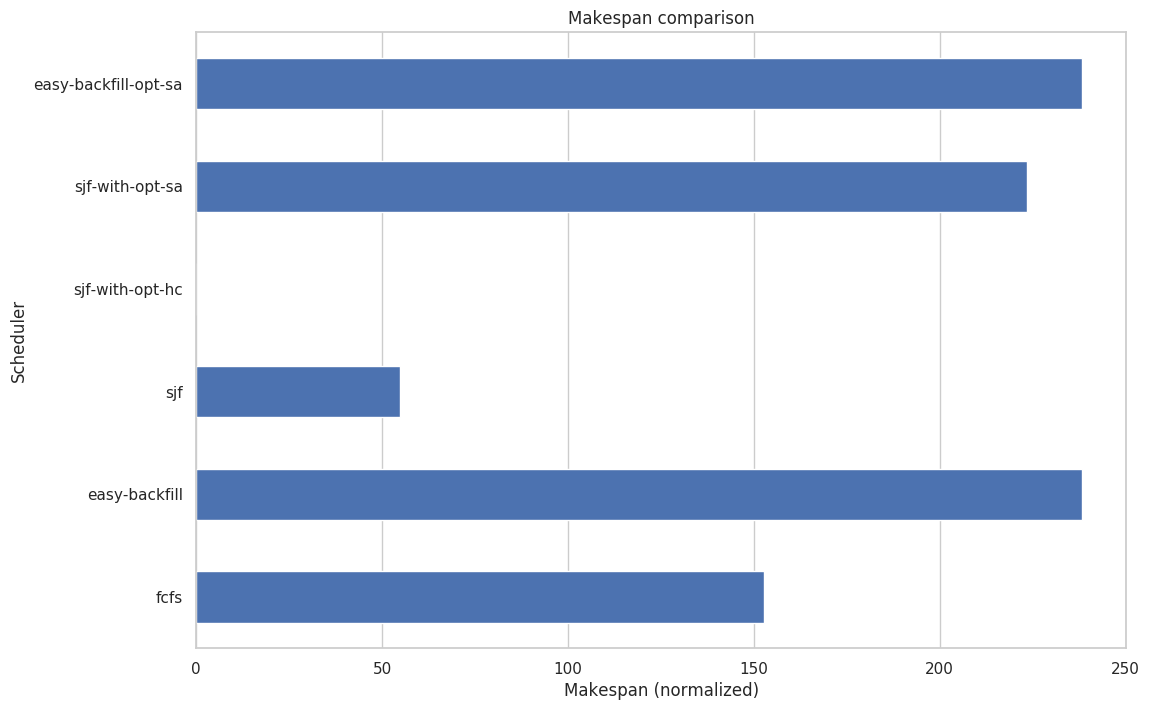

In [13]:
df_metrics = metrics.copy()
df_metrics['makespan'] = abs(df_metrics['makespan'] - df_metrics['makespan'].max())

ax = df_metrics['makespan'].plot.barh(figsize=(12, 8))
ax.set_xlabel('Makespan (normalized)')
ax.set_ylabel('Scheduler')
ax.set_title('Makespan comparison') 
ax.grid(axis='y')

In [42]:
metrics_df = create_all_metrics_df()
metrics_df

,schedule,waiting_time,turnaround_time,slowdown
0,fcfs,0.000030,19.717915,1.000002
1,fcfs,19.719885,96.082207,1.258241
2,fcfs,96.084178,101.697788,18.116289
3,fcfs,101.699759,120.199439,6.497379
4,fcfs,19.719900,331.307441,1.063288
...,...,...,...,...
2445,easy-backfill-opt-sa,1786.255696,2440.638118,3.729682
2446,easy-backfill-opt-sa,2440.640109,2443.051514,1013.123764
2447,easy-backfill-opt-sa,2443.052991,2454.255854,219.073978
2448,easy-backfill-opt-sa,2454.257331,2466.224970,206.074485


# Waiting Time


In [16]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,fcfs,easy-backfill,sjf,sjf-with-opt-hc,sjf-with-opt-sa,easy-backfill-opt-sa
count,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000
mean,1859.854438,1007.751128,1787.141421,1734.020775,1649.568412,1009.369980
std,2456.555730,1608.219207,2633.121662,2579.359781,2472.964293,1741.519522
min,0.000030,0.000030,0.000030,0.000030,0.000030,0.000030
25%,225.395791,30.538780,91.465156,104.549358,87.540808,30.775747
50%,1042.528974,392.430024,831.401689,806.225975,777.504324,360.537041
75%,2363.795390,1262.565636,2296.503031,2214.458712,2162.419788,1239.660422
max,15979.455909,14775.611934,17830.260609,17237.522965,18795.717067,14211.630007


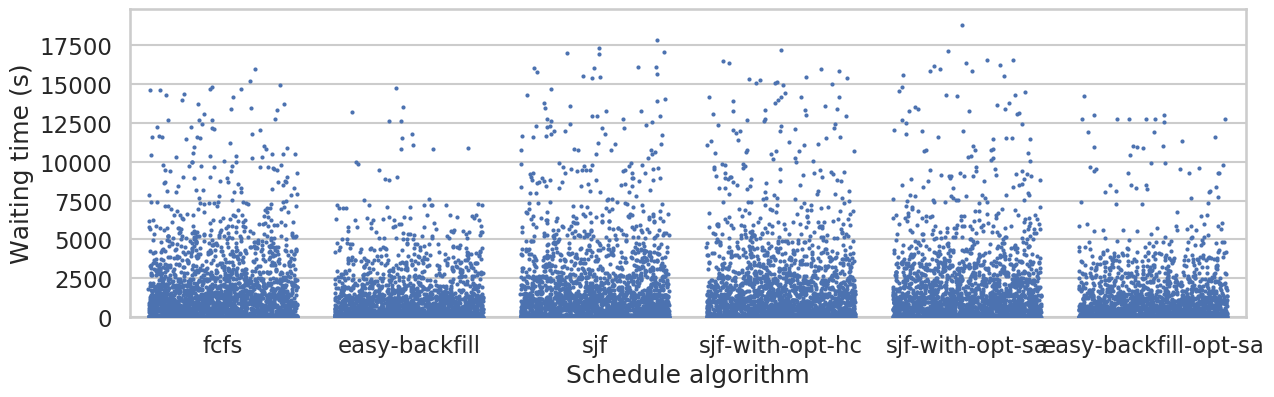

In [17]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']].nlargest(n=4000, columns='waiting_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('Waiting time (s)')
    ax.set_xlabel('Schedule algorithm')
fig.savefig('results/waiting-time_dist.pdf', bbox_inches='tight')

Text(0.5, 0, 'Schedule algorithm')

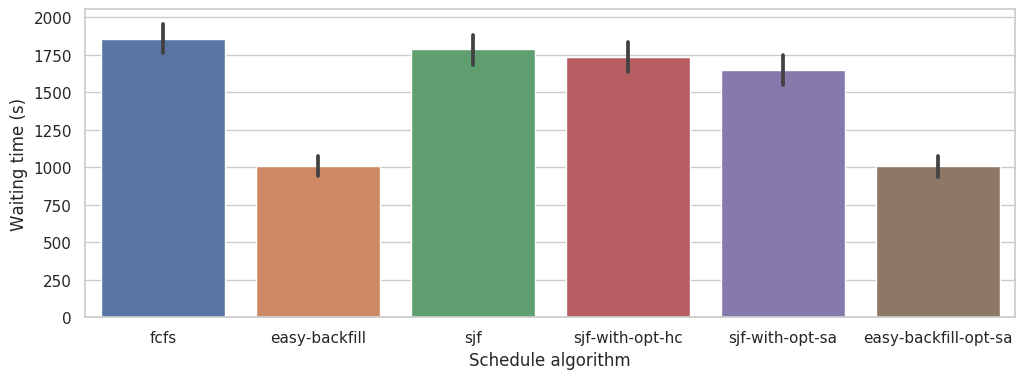

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(data=waiting_times, ax=ax)
ax.set_ylabel('Waiting time (s)')
ax.set_xlabel('Schedule algorithm')
#fig.savefig('results/waiting-time_mean.pdf', bbox_inches='tight')

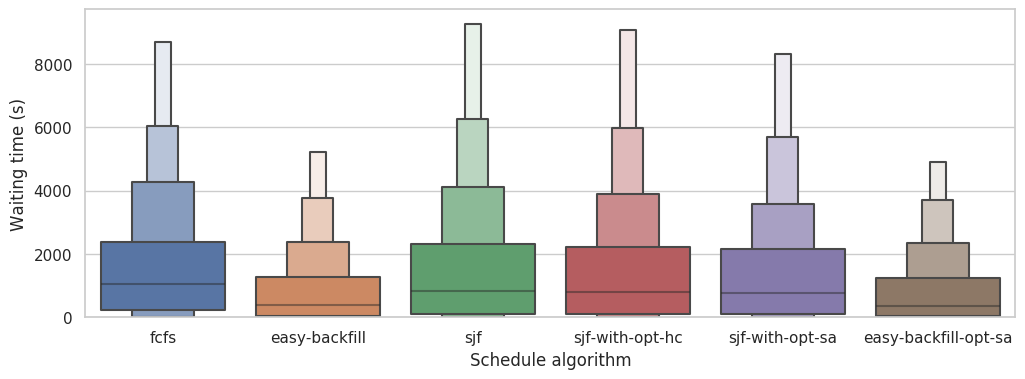

In [22]:
fig, ax = plt.subplots(figsize=(12,4))
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
ax.set_ylabel('Waiting time (s)')
ax.set_xlabel('Schedule algorithm')
fig.savefig('results/waiting-time_boxen.pdf', bbox_inches='tight')

# Turnarround Time


In [23]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,fcfs,easy-backfill,sjf,sjf-with-opt-hc,sjf-with-opt-sa,easy-backfill-opt-sa
count,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000
mean,1993.135828,1140.903382,1920.603502,1867.802765,1783.177896,1142.348570
std,2474.493959,1666.079415,2651.941708,2597.719346,2492.215190,1797.730502
min,0.217383,0.217368,0.217383,0.217368,0.217368,0.217368
25%,368.236092,70.964799,223.361942,215.832233,202.246061,74.794730
50%,1225.993548,521.420902,992.279873,987.792617,943.013669,504.933360
75%,2535.583693,1474.075469,2499.833054,2367.586881,2352.204766,1393.078563
max,15984.460196,14783.485544,17840.972814,17248.235170,18844.112147,14866.012430


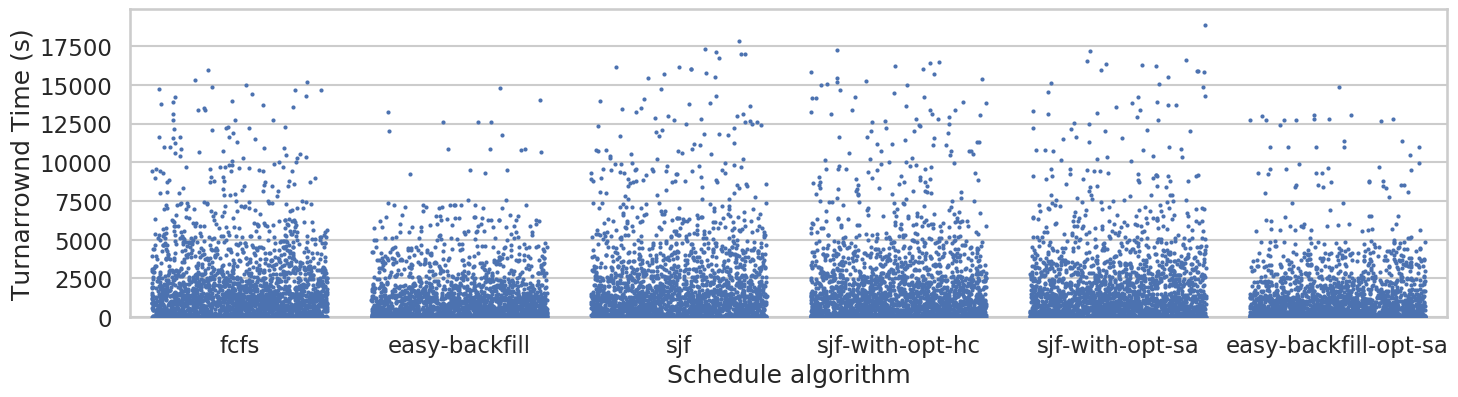

In [26]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'turnaround_time']].nlargest(n=4000, columns='turnaround_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(17,4))
    sns.stripplot(data=largest, x='schedule', y='turnaround_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
#     ax.set_ylim(top=2.5*10**6)

    ax.set_ylabel('Turnarrownd Time (s)')
    ax.set_xlabel('Schedule algorithm')
fig.savefig('results/turnaround-time_dist.pdf', bbox_inches='tight')

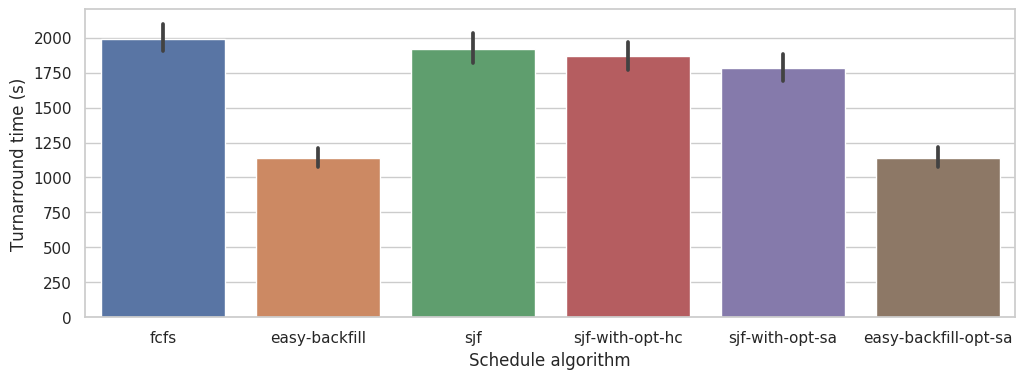

In [29]:
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(data=turnaround_times, ax=ax)
ax.set_ylabel('Turnarround time (s)')
ax.set_xlabel('Schedule algorithm')
fig.savefig('results/turnaround-time_mean.pdf', bbox_inches='tight')

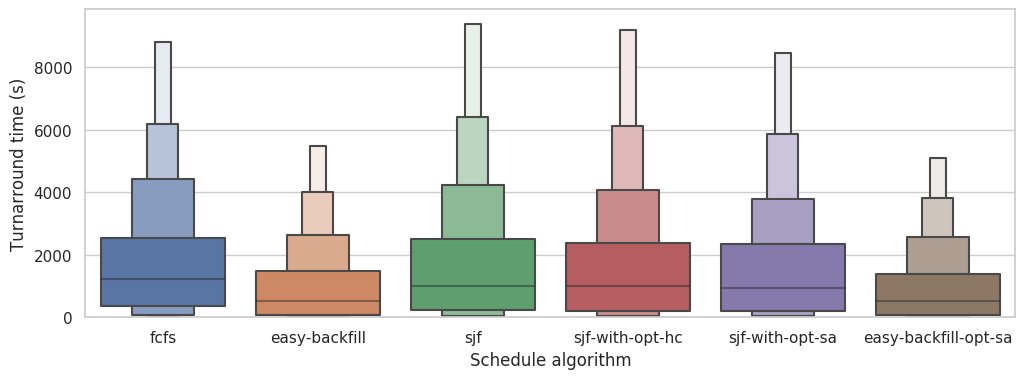

In [31]:
fig, ax = plt.subplots(figsize=(12,4))
sns.boxenplot(data=turnaround_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
ax.set_ylabel('Turnarround time (s)')
ax.set_xlabel('Schedule algorithm')
fig.savefig('results/turnaround-time_boxen.pdf', bbox_inches='tight')

# Slowdown


In [50]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,fcfs,easy-backfill,sjf,sjf-with-opt-hc,sjf-with-opt-sa,easy-backfill-opt-sa
count,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000,2450.000000
mean,384.995201,190.012579,354.885370,330.019987,300.784374,180.202477
std,2012.460374,1084.798295,1761.091783,1531.428075,1475.066464,1068.535730
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.999131,2.137837,2.709113,3.164334,2.975787,2.132912
50%,38.329465,9.657220,25.929375,25.299644,23.946324,9.888620
75%,205.894541,75.423721,168.433726,158.380210,151.059699,71.527635
max,67553.551748,27746.150368,46457.158793,44362.581022,47834.887522,39161.831361


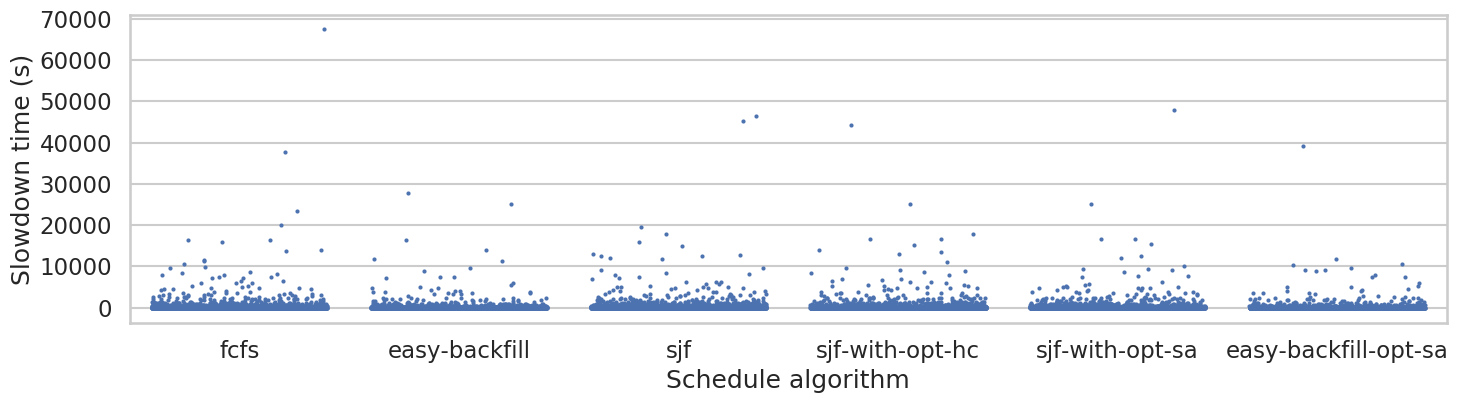

In [44]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'slowdown']].nlargest(n=4000, columns='slowdown') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(17,4))
    sns.stripplot(data=largest, x='schedule', y='slowdown', ax=ax, size=3, jitter=0.4)
    ax.set_ylabel('Slowdown time (s)')
    ax.set_xlabel('Schedule algorithm')
fig.savefig('results/slowdown_dist.pdf', bbox_inches='tight')

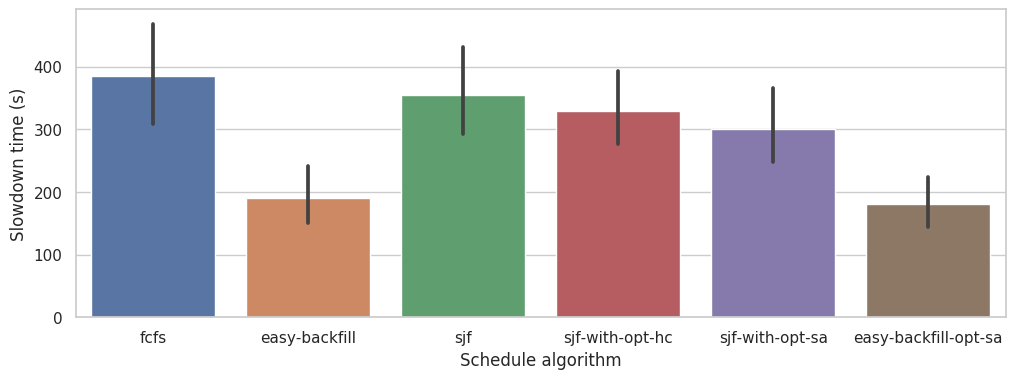

In [45]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(data=slowdown, ax=ax)
ax.set_ylabel('Slowdown time (s)')
ax.set_xlabel('Schedule algorithm')
fig.savefig('results/slowdown_mean.pdf', bbox_inches='tight')

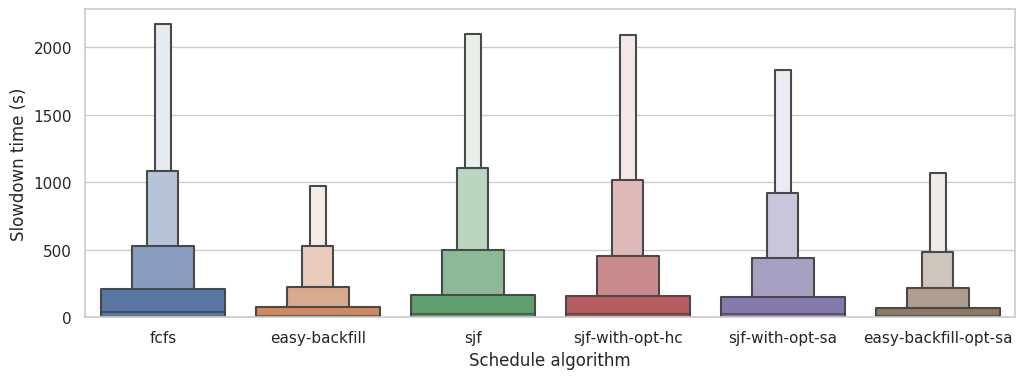

In [46]:
fig, ax = plt.subplots(figsize=(12,4))
sns.boxenplot(data=slowdown, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
ax.set_ylabel('Slowdown time (s)')
ax.set_xlabel('Schedule algorithm')
fig.savefig('results/slowdown_boxen.pdf', bbox_inches='tight')

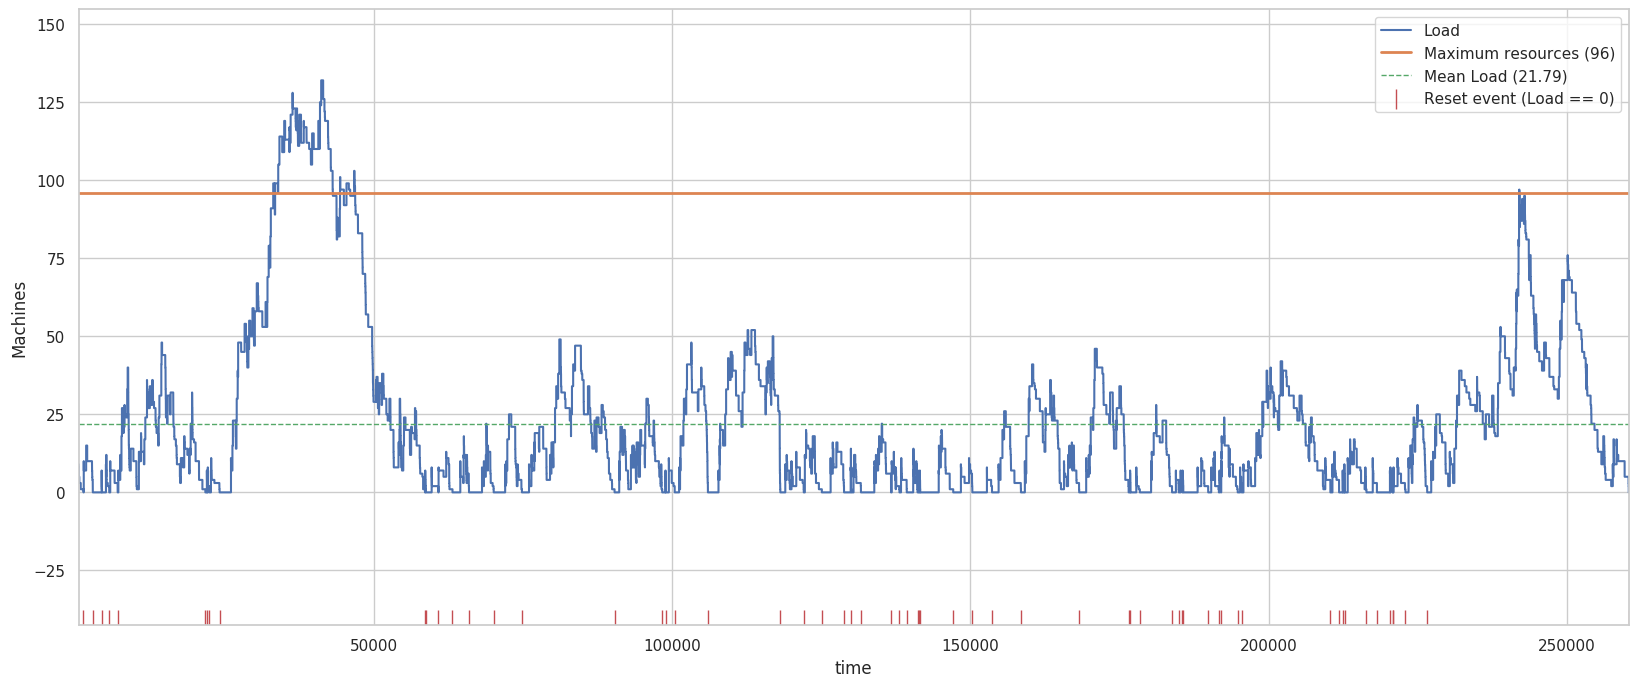

In [47]:
fig, ax = plt.subplots(figsize=(20,8))
evalys.visu.legacy.plot_load(jobsets['fcfs'].queue, nb_resources=96, ax=ax)

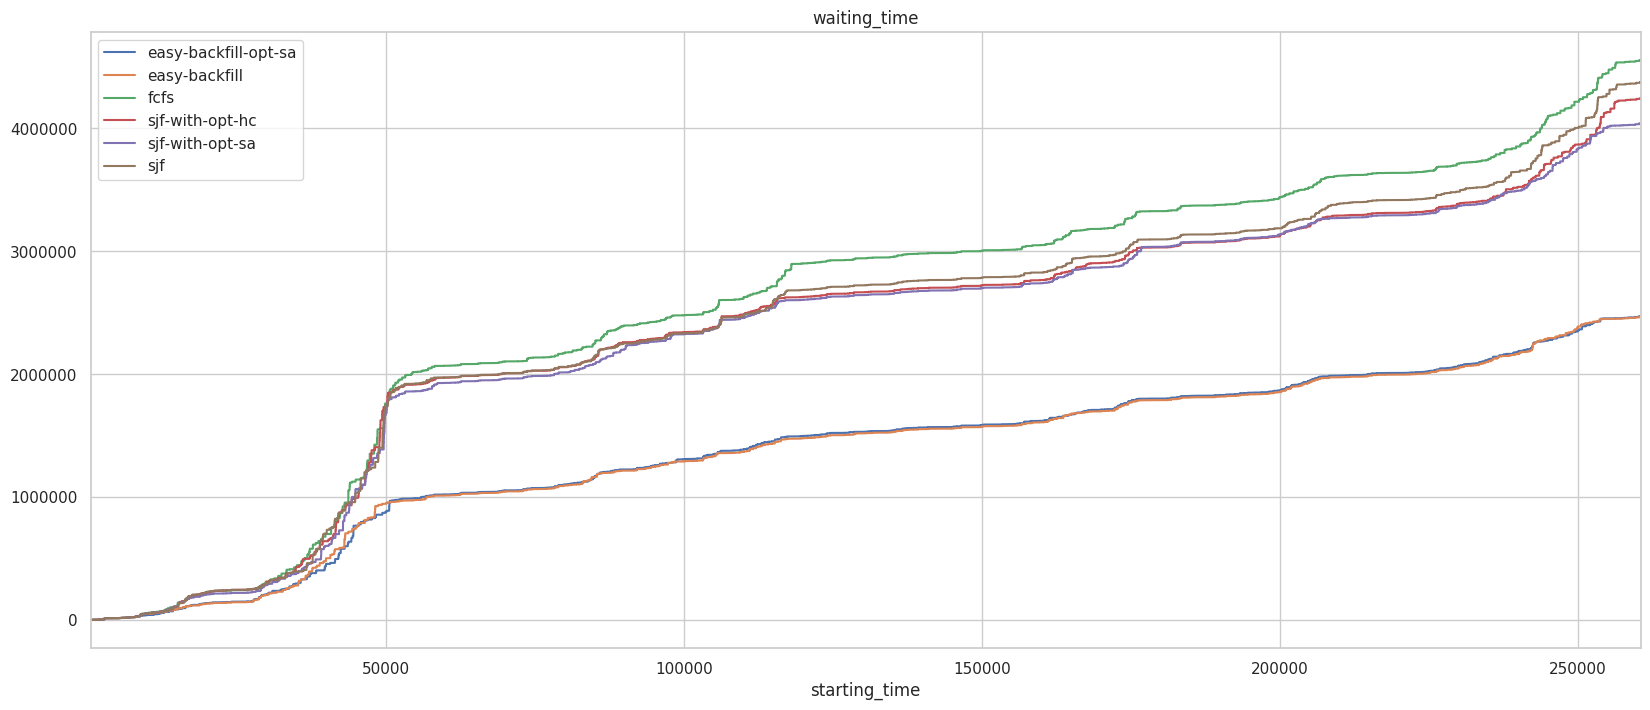

In [48]:
fig, ax = plt.subplots(figsize=(20,8))
evalys.visu.legacy.plot_series('waiting_time', jobsets)